In [64]:
import sys
sys.path.append('../../')

In [65]:
from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter

from numpy.polynomial.polynomial import polyfit, polyval

In [81]:
def DFA_main(DATA):
    # output:
    # F_n: RMS(Root Mean Squared) values in each window length
    # Alpha1: the Hurst exponent
    N = len(DATA)  # length of the data
    # Customized the below window lengths to your interest
    win_lengths = np.arange(5, len(DATA)/2, 200*20).astype(int) # how many different win_lengths, customized to your data
    Nw = len(win_lengths) # number of different win_length
    F_n = np.zeros(Nw) # initialize RMS values in the FDA time series
    order=1 # (default to 1 in DFA_main function);

    for iw in range(Nw):
        win_length=win_lengths[iw]
        n = int(np.floor(N / win_length))  # the number of windows
        N1 = n * win_length  # new length of the truncated data 
        # initialize y
        y = np.zeros(N1)  # sum of deviations from the grand mean in all data length
        # initialize fitcoef
        mean1 = np.mean(DATA[:N1]) # grand mean of the truncated data
        # sum of deviations from the grand mean in all data length
        for i in range(N1):
            y[i] = np.sum(DATA[:i+1] - mean1)

        # polynomial coefficients in each window
        fitcoef = np.zeros((n, order + 1))
        for j in range(n):
            fitcoef[j,:] = np.polyfit(np.arange(1, win_length+1), y[j*win_length:(j+1)*win_length], order)
        
        # initialize Yn (the new Y values in each window)
        Yn = np.zeros(N1)
        for j in range(n): # the number of windows
            Yn[j*win_length:(j+1)*win_length] = np.polyval(fitcoef[j,:], np.arange(1, win_length+1))

        sum1 = np.sum((y.T - Yn)**2) / N1 # take the mean square
        sum1 = np.sqrt(sum1) # take the root
    
        F_n[iw] = sum1 # the final RMS (root mean squared value)

    A = np.polyfit(np.log10(win_lengths), np.log10(F_n), 1)
    Alpha1 = A[0]
    FitValues = np.polyval(A, np.log10(win_lengths))
    # return Alpha1
    return win_lengths, F_n, Alpha1, FitValues
    

In [67]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes   


In [68]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [69]:
def segmenteegdata(eegdata,epochlength,samplingrate):
    epoch = int(epochlength*samplingrate)
    nsamp = np.shape(eegdata)[0]
    nchan = np.shape(eegdata)[1]
    nepoch = int(nsamp/epoch)
    nsamp = nepoch*epoch
    segdata = np.reshape(eegdata[0:nsamp,0:nchan],(nepoch,epoch,nchan))
    return segdata


In [70]:
epoch = 1 #units: seconds
matfile = list()
filedir="../../"
pathname = 'Cleaned_data/'
# for file in listdir(filedir+pathname):
# 	if file.endswith(".mat"):
# 		matfile.append(file)

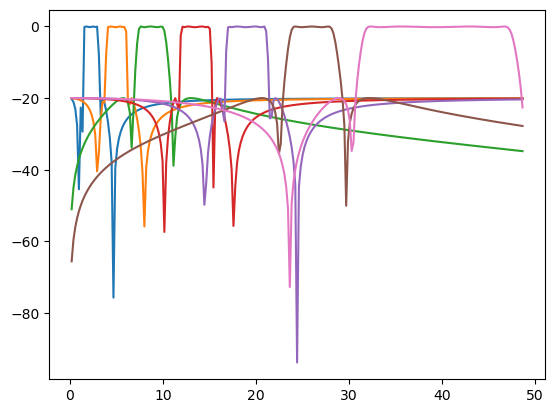

In [71]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1.5,3],[4,6],[7.5,10],[12,15],[17 ,21],[24,28],[32,47]]
stopbands = [[1,3.5],[3.5,6.5],[6.5,11],[11,16],[16,22],[22,30],[30,50]]
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    plt.plot(w[1:250],20*np.log10(np.abs(h[1:250])))

In [72]:
# organize file in time sequence
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [73]:
hilbert_data288=dict(); n=0
for ses in range(0,1):
	filename='clean_'+str(filedates[ses])+'.mat'
	# load one session data
	[eeg, intervals, samples, condition_index, session, sr, bpchan, 
			condition_Names, channels, chan_labels, sessionTypes] \
				= loaddata(filedir+pathname+filename)
	# construct lowpass filter for downsampling
	sos_low, w,h = makefiltersos(sr,50,55)
	for trl in range(0,1): # for each trial
		#align the length of the two files. 
		nsamp1 = np.shape(eeg[0][trl])[0]
		nsamp2 = np.shape(eeg[1][trl])[0]
		nsamp = np.min((nsamp1,nsamp2))
		for subj in range(0,1): # for each subject
			# average referencing
			trialdata = avref(eeg[subj][trl][0:nsamp,0:32]) 
			# lowpass filtering
			trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
			# downsampling
			trialdatanew = trialdata[range(0,nsamp,downsample),:]
			filtdata = dict()
			# time = dict()
			hilbertdata = dict()
			empirical_ampcorr = dict()
			phasecorr = dict() #need to to do this still. 
			for freq in range(len(passbands)):
				filtdata[freq] = sosfiltfilt(esos[freq],trialdatanew,axis = 0,padtype ='odd')
				hilbertdata[freq] = hilbert(filtdata[freq],axis = 0)
				empirical_ampcorr[freq] = np.corrcoef(np.transpose(np.abs(hilbertdata[freq])))
			# put all variables needed in a dictionary for each trial (288 trials)
			trial_dict=dict()
			trial_dict['session']=session-1 # 0 for synch, 1 for synco
			trial_dict['sessionTypes']=sessionTypes[session-1] # string value "synch" or "synco"
			trial_dict['ses']=ses # session number in time sequence from 0 to 11
			trial_dict['subj']=subj # 0 for L subject, 1 for R subject
			trial_dict['trl']=trl # trial number in time sequence
			trial_dict['condition_index']=condition_index[trl] # condition index 0 to 3
			trial_dict['hilbertdata']=hilbertdata
			trial_dict['empirical_ampcorr']=empirical_ampcorr
			hilbert_data288[n]=trial_dict
			n+=1


# takes 46s for one ses in HP laptop
# takes 40s for one ses in hnlb 
# total estimate 40x12 = 8 min

In [39]:
hilbert_144x2=[[]*2]*144

In [ ]:
len(hilbert_144x2[143,])

In [28]:
# # Alpha_all=np.zeros((144,2,7,32))
# condition_ind_all=np.zeros((144,2))
# session_all=np.zeros((144,2))
# subj_all=np.zeros((144,2))
# ses_all=np.zeros((144,2))
# hilbert_144x2=[[]*2]*144
# n=0
# for ses in range(0,1):
# 	filename='clean_'+str(filedates[ses])+'.mat'
# 	# load one session data
# 	[eeg, intervals, samples, condition_index, session, sr, bpchan, 
# 			condition_Names, channels, chan_labels, sessionTypes] \
# 				= loaddata(filedir+pathname+filename)
# 	# construct lowpass filter for downsampling
# 	sos_low, w,h = makefiltersos(sr,50,55)
# 	for trl in range(0,1): # for each trial
# 		#align the length of the two files. 
# 		nsamp1 = np.shape(eeg[0][trl])[0]
# 		nsamp2 = np.shape(eeg[1][trl])[0]
# 		nsamp = np.min((nsamp1,nsamp2))
		
# 		for subj in range(0,1): # for each subject
# 			# average referencing
# 			trialdata = avref(eeg[subj][trl][0:nsamp,0:32]) 
# 			# lowpass filtering
# 			trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
# 			# downsampling
# 			trialdatanew = trialdata[range(0,nsamp,downsample),:]
# 			filtdata = dict()
# 			# time = dict()
# 			hilbertdata = dict()
# 			# empirical_ampcorr = dict()
# 			phasecorr = dict() #need to to do this still. 
# 			for freq in range(0,1): #len(passbands)):
# 				filtdata[freq] = sosfiltfilt(esos[freq],trialdatanew,axis = 0,padtype ='odd')
# 				hilbertdata[freq] = hilbert(filtdata[freq],axis = 0)
# 				# empirical_ampcorr[freq] = np.corrcoef(np.transpose(np.abs(hilbertdata[freq])))
# 				# for chan in range(0,1):
# 				# 	Alpha1=DFA_main(np.abs(hilbertdata[freq][1:1000,chan]))
# 				# 	# put all variables into 144x2 np array
# 				# 	Alpha_all[n,subj,freq,chan]=Alpha1
			
# 			condition_ind_all[n,subj]=condition_index[trl]
# 			session_all[n,subj]=session-1 # 0 for synch, 1 for synco
# 			subj_all[n,subj]=subj
# 			ses_all[n,subj]=ses
# 		n+=1   
            
# # put all variables needed in a dictionary for each trial (288 trials)
# outdict=dict()
# outdict['Alpha_all']=Alpha_all
# outdict['session_all']=session_all # 0 for synch, 1 for synco
# outdict['ses_all']=ses_all # session number in time sequence from 0 to 11
# outdict['subj_all']=subj_all # 0 for L subject, 1 for R subject
# outdict['trl']=trl # trial number in time sequence
# outdict['condition_ind_all']=condition_ind_all # condition index 0 to 3

# # save syn_pcorr (wasn't able to save)
# savemat('DFA144X2',outdict,store_python_metadata=True)

# # takes 10 hours to go to n = 6 

In [74]:
freq=0; chan=0
np.shape(hilbertdata[freq][:,chan])

(25782,)

In [ ]:
25782/200

128.91

On my laptop, DFA for trial length 64512 samples (200 sampling rate, about 2 minutes) long single channel time series takes 13 min. 
Total time 13 min x 7 frequencies x 32 channels x 2 subjects x 12 trials x 12 session = 582.4 days

In [ ]:
7*32*2*12*12

64512

In [76]:
2.3*64512/60/60/24

1.7173333333333332

In [75]:
# check how much time needed
freq=0; chan=0
Alpha1=DFA_main(np.abs(hilbertdata[freq][:,chan]))
# 13 min

In [52]:
x=np.mean(np.abs(hilbertdata[0]))
np.shape(x)

()

In [12]:
np.shape(hilbertdata[1])

(23171, 32)

In [ ]:
# import pickle
# # save dictionary to pickle file
# with open('hilbert_data288.pickle', 'wb') as file:
#     pickle.dump(hilbert_data288, file, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:

import pickle
# load a pickle file
with open("hilbert_data288.pickle", "rb") as file:
    hilbert_data288 = pickle.load(file)

Things to be added now: 
(1) incorporate the analysis of the inverse covariance on the hilbertdata.  Dont forget to remove the mean.  Should be more reasonable to manage now, since there are just 6 bands. 
(2) incorporate the dfa analysis on the envelope time series. (abs of hilbertdata) 
After this are some plots that are useful to visualize things. 
(3) Its going to be more difficult to save all these hilbert outputs of different sizes into one big array.  Do we need to really save it? 
(4) I need to make a phase version of this.  But I am confused. 

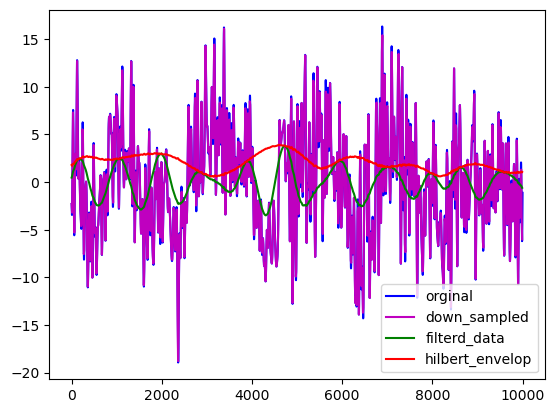

In [35]:
freq=0; chan=0

plt.plot(range(10000),trialdata[0:10000,chan],'b',label='orginal')

plt.plot(range(0,10000,10),trialdatanew[0:1000,chan],'m',label='down_sampled')

plt.plot(range(0,10000,10),filtdata[freq][0:1000,chan],'g',label='filterd_data')

plt.plot(range(0,10000,10),np.abs(hilbertdata[freq][0:1000,chan]),'r',label='hilbert_envelop')

plt.legend()

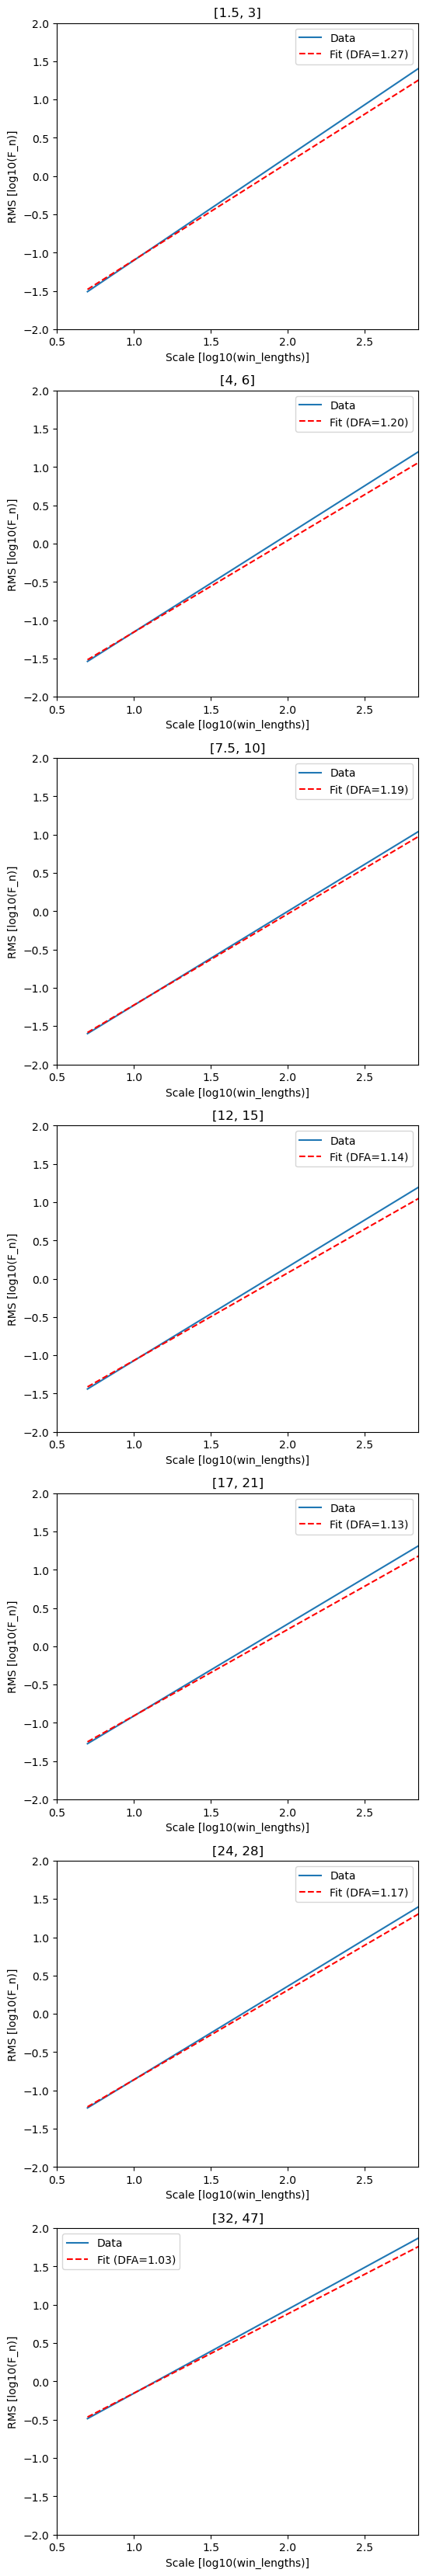

In [82]:
# try DFA
freq=0; chan=0
fig, ax = plt.subplots(7,1,figsize=(6*1, 6*7))
for freq in range(len(passbands)):
    x=np.mean(np.abs(hilbertdata[freq][:,chan]))
    win_lengths, F_n, Alpha1, FitValues=DFA_main(np.abs(hilbertdata[freq][:,chan])-x)
    plt.sca(ax[freq])
    plt.plot(np.log10(win_lengths), np.log10(F_n))
    plt.xlabel('Scale [log10(win_lengths)]')
    plt.ylabel('RMS [log10(F_n)]')
    plt.plot(np.log10(win_lengths), FitValues, 'r--')
    plt.legend(['Data', f"Fit (DFA={Alpha1:.2f})"])
    plt.title(str(passbands[freq]))
    plt.xlim(0.5, 2.85)
    plt.ylim(-2,2)


In [ ]:
# # DFA 288 trials
# Alpha_all=np.zeros((288,7))
# condition_ind_all=np.zeros((288,1))
# session_all=np.zeros((288,1))
# subj_all=np.zeros((288,1))
# for n in range(288):
#     hilbertdata=hilbert_data288[n]['hilbertdata']
#     condition_ind_all[n]=hilbert_data288[n]['condition_index']
#     session_all[n]=hilbert_data288[n]['session']
#     subj_all[n]=hilbert_data288[n]['subj']
#     for freq in range(7):
#         x=np.mean(np.abs(hilbertdata[freq][0:1000,6]))
#         win_lengths, F_n, Alpha_all[n,freq], FitValues=DFA_main(np.abs(hilbertdata[freq])-x)
# # take 20 min

In [13]:
# # save DFA results
# outdict=dict()
# outdict['Alpha_all']=Alpha_all
# outdict['condition_ind_all']=condition_ind_all
# outdict['session_all']=session_all
# outdict['subj_all']=subj_all
# # save syn_pcorr
# savemat('DFA288',outdict,store_python_metadata=True)

In [3]:
# # load syn_pcorr
# outdict=loadmat('DFA288.mat')
# Alpha_all=outdict["Alpha_all"]
# condition_ind_all=outdict["condition_ind_all"]
# session_all=outdict["session_all"]
# subj_all=outdict["subj_all"]

In [ ]:
for j in range(len(passbands)):
    plt.figure()
    plt.imshow(empirical_ampcorr[j])
    plt.colorbar()
    plt.title(str(passbands[j]))

In [ ]:
from scipy.stats import sem

DFA_means=np.zeros((2,4))
DFA_sems=np.zeros((2,4))


np.where(condition_ind_all==0 and session_all==0, )

In [11]:
np.where(subj_all==1)

(array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
         27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
         53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
         79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
        105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
        131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
        157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
        183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
        209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
        235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259,
        261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285,
        287]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
np.where(session_all==1)

(array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
        237, 238, 239, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
        274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
        287]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
np.where(condition_ind_all==3)[0]


array([  4,   5,  12,  13,  18,  19,  28,  29,  36,  37,  42,  43,  50,
        51,  60,  61,  70,  71,  74,  75,  84,  85,  94,  95,  96,  97,
       110, 111, 114, 115, 120, 121, 134, 135, 138, 139, 148, 149, 158,
       159, 166, 167, 172, 173, 182, 183, 190, 191, 196, 197, 206, 207,
       208, 209, 220, 221, 230, 231, 232, 233, 244, 245, 254, 255, 262,
       263, 268, 269, 278, 279, 286, 287])